In [3]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
%matplotlib inline
fitdate = '2020-09-04'
fitfiles = [f'./fits/{subjdir}/{file}'
            for subjdir in os.listdir('./fits/') 
            for file in os.listdir(f'./fits/{subjdir}')
            if re.match(f'.*{fitdate}.*\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    filedata[filename] = data


In [4]:
animals = list(set([filedata[s]['sessinfo']['subject_nickname'] for s in filedata]))
sess_fitscores = [{'subject': filedata[s]['sessinfo']['subject_nickname'],
                   'sessdate' : str(filedata[s]['sessinfo']['session_start_time'].date()),
                   'probe': filedata[s]['sessinfo']['probe_idx'],
                   'fitscores': filedata[s]['fitobj'].score()} for s in filedata]
scoredf = pd.DataFrame(sess_fitscores)

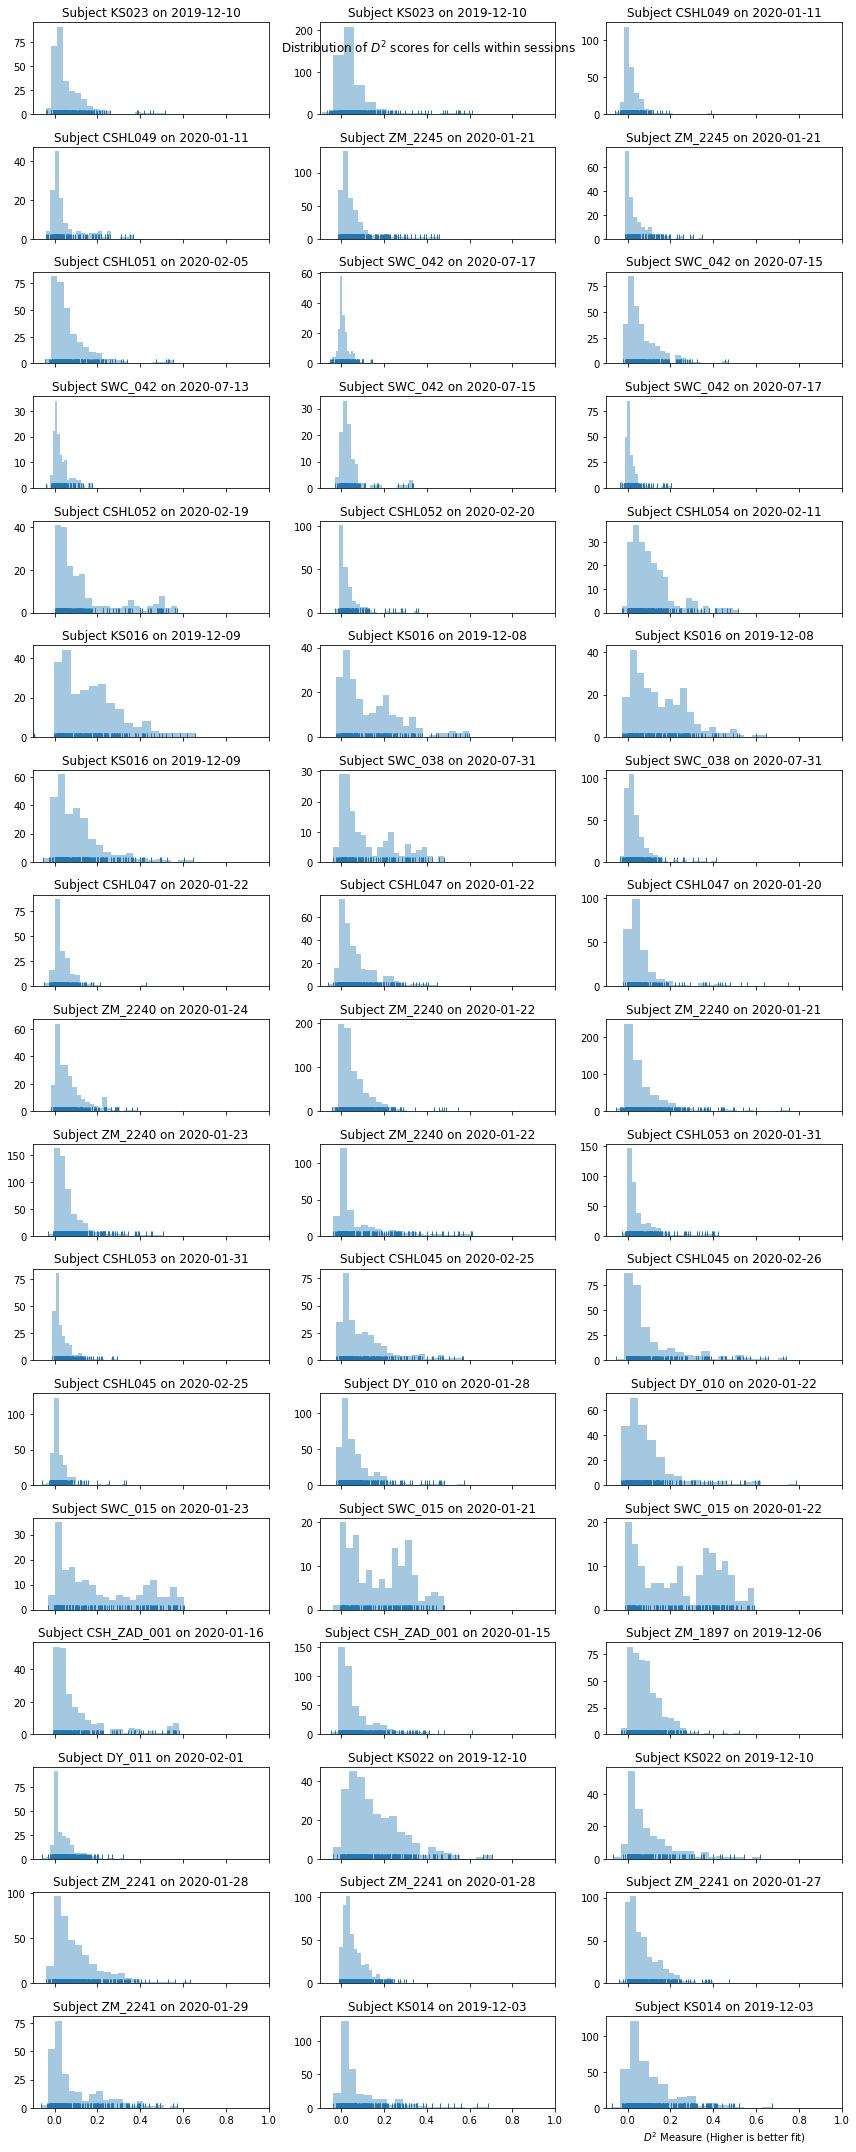

In [5]:
fig, ax = plt.subplots(np.ceil(len(scoredf) / 3).astype(int), 3, figsize=(12, 30), sharex=True)
ax = ax.flatten()
for i, scoreset in scoredf.iterrows():
    sns.distplot(scoreset.fitscores, bins=20, ax=ax[i], rug=True, kde=False)
    ax[i].set_title(f'Subject {scoreset.subject} on {scoreset.sessdate}')
ax[-1].set_xlabel('$D^2$ Measure (Higher is better fit)')
ax[-1].set_xlim([-0.1, 1])
plt.suptitle('Distribution of $D^2$ scores for cells within sessions')
plt.tight_layout()


Text(0.5, 1.0, 'Distribution of $R^2$ for P(Left) and Pstrack')

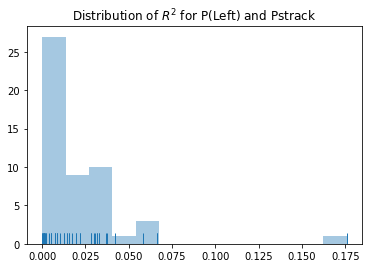

In [6]:
psytrack_corrs = {}
for filename in filedata:
    trialsdf = filedata[filename]['fitobj'].trialsdf
    psytrack_corrs[filename] = np.corrcoef(trialsdf['bias'] - trialsdf['bias'].mean(), trialsdf['probabilityLeft'])[0, 1]
sns.distplot(np.array(list(psytrack_corrs.values()))**2, rug=True, kde=False)
plt.title('Distribution of $R^2$ for P(Left) and Pstrack')

In [7]:
from ibl_pipeline.analyses import behavior
from ibl_pipeline import subject
from ibl_pipeline.utils import psychofit as psy
from datetime import timedelta

xx = np.linspace(-100, 100, 100)
psychometric = behavior.PsychResultsBlock * subject.Subject
for filename in filedata:
    sinf = filedata[filename]['sessinfo']
    sesspsy = psychometric & 'subject_nickname = "{}"'.format(sinf['subject_nickname']) &\
        'session_start_time = "{}"'.format(sinf['session_start_time'])
    sessdf = sesspsy.fetch(format='frame').reset_index()
    low, med, high = sessdf[sessdf.prob_left_block == 20], sessdf[sessdf.prob_left_block == 50], sessdf[sessdf.prob_left_block == 80]
    left_low = psy.erf_psycho_2gammas(np.array([low.iloc[0].bias,
                                                low.iloc[0].threshold,
                                                low.iloc[0].lapse_low,
                                                low.iloc[0].lapse_high]), xx)
    left_med = psy.erf_psycho_2gammas(np.array([med.iloc[0].bias,
                                                med.iloc[0].threshold,
                                                med.iloc[0].lapse_low,
                                                med.iloc[0].lapse_high]), xx)
    left_high = psy.erf_psycho_2gammas(np.array([high.iloc[0].bias,
                                                 high.iloc[0].threshold,
                                                 high.iloc[0].lapse_low,
                                                 high.iloc[0].lapse_high]), xx)
    filedata[filename]['psyfuncs'] = (left_low, left_med, left_high)
    filedata[filename]['psychdata'] = sessdf[['prob_left_block', 'signed_contrasts', 'prob_choose_right']].set_index('prob_left_block')

Connecting gercek@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as berk.gercek


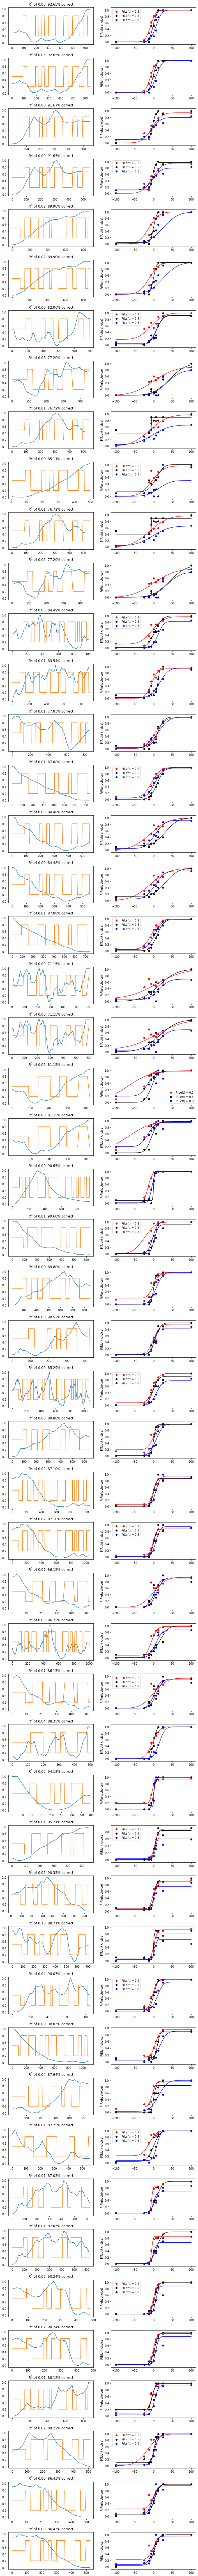

In [8]:
fig, ax = plt.subplots(len(scoredf), 2, figsize=(10, len(scoredf) * 2.5))
for i, (filename, fitdata) in enumerate(filedata.items()):
    trialsdf = fitdata['fitobj'].trialsdf
    psychdata = fitdata['psychdata']
    corrval = np.corrcoef(trialsdf.bias - trialsdf.bias.mean(), trialsdf.probabilityLeft)[0, 1]**2
    perc_corr = np.sum(trialsdf.feedbackType == 1) / len(trialsdf)
    meansub = trialsdf.bias - trialsdf.bias.mean()
    shift_rescale = (meansub - meansub.min()) / (meansub - meansub.min()).max()
    ax[i, 0].plot(shift_rescale, label='Psytrack estimate')
    ax[i, 0].plot(trialsdf.probabilityLeft, label='P(Left)')
    ax[i, 0].set_title(f'$R^2$ of {corrval:0.2f}, {perc_corr * 100:0.02f}% correct')
    ax[i, 1].scatter(psychdata.loc[20].signed_contrasts * 100,
                  psychdata.loc[20].prob_choose_right, label='P(Left) = 0.2', color='red')
    ax[i, 1].plot(xx, fitdata['psyfuncs'][0], color='red')
    ax[i, 1].scatter(psychdata.loc[50].signed_contrasts * 100,
                  psychdata.loc[50].prob_choose_right, label='P(Left) = 0.5', color='black')
    ax[i, 1].plot(xx, fitdata['psyfuncs'][1], color='black')
    ax[i, 1].scatter(psychdata.loc[80].signed_contrasts * 100,
                  psychdata.loc[80].prob_choose_right, label='P(Left) = 0.8', color='blue')
    ax[i, 1].plot(xx, fitdata['psyfuncs'][2], color='blue')
    ax[i, 1].set_ylabel('P(Right choice)')
    if i % 3 == 0:
        ax[i, 1].legend()


    
plt.tight_layout()

In [9]:
from ibl_pipeline import histology


no_histology = []
observed_regions = []
for key, ses in filedata.items():
    regions = histology.ProbeTrajectory *\
        histology.ClusterBrainRegion & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                        'session_start_time': ses['sessinfo']['session_start_time'],
                                        'probe_idx': ses['sessinfo']['probe_idx']} &\
        'insertion_data_source = "Histology track"'
    plan_coords = histology.ProbeTrajectory & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                               'session_start_time': ses['sessinfo']['session_start_time'],
                                               'probe_idx': ses['sessinfo']['probe_idx']} &\
        'insertion_data_source = "Planned"'
    pcoordf = plan_coords.fetch(format='frame').reset_index()
    unitdf = regions.fetch(format='frame').reset_index()
    if len(unitdf) == 0:
        regions = histology.ProbeTrajectory *\
            histology.ClusterBrainRegion & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                            'session_start_time': ses['sessinfo']['session_start_time'],
                                            'probe_idx': ses['sessinfo']['probe_idx']} &\
            'insertion_data_source = "Ephys aligned histology track"'
        unitdf = regions.fetch(format='frame').reset_index()
        if len(unitdf) == 0:
            no_histology.append(key)
            continue
    ses['unit_regions'] = unitdf[['cluster_id', 'acronym']].set_index('cluster_id', verify_integrity=True)
    ses['coords'] = unitdf[['x', 'y', 'z']].iloc[0].values
    try:
        ses['planned_coords'] = pcoordf[['x', 'y', 'z']].iloc[0].values
    except:
        ses['planned_coords'] = np.array([0, 0, 0])
    observed_regions.extend(unitdf.acronym.unique())
_ = [filedata.pop(x) for x in no_histology]
coordset = [x['coords'] for x in filedata.values()]
allregions = list(set(observed_regions))

sess_strs = {s['sessinfo']['subject_nickname'] + ' from ' +
             str(s['sessinfo']['session_start_time'].date()) + ' probe: ' +
             str(s['sessinfo']['probe_idx']) : fn for fn, s in filedata.items()}

Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [10]:
sig_count = {region: {'stimonL': 0,
                      'stimonR': 0,
                      'correct': 0,
                      'incorrect': 0,
                      'wheel': 0,
                      'scores': []} for region in allregions}
tot_units = {region: 0 for region in allregions}
abstotal = 0
missing_units = {fn : [] for fn in filedata}

criterion = 0.1  # criterion for including a unit in the significance map.
sem_num = 5  # number of SEMs a value within the kernel must be to be counted as significant
for key, ses in filedata.items():
    scores = ses['fitobj'].score()
    ses['scores'] = scores
    ses['significance'] = pd.DataFrame(index=ses['weights']['stimonL'].index,
                                       columns=ses['weights'].keys(), dtype=bool)
    ses['significance'].iloc[:, :] = False
    abstotal += len(scores)
    for cell in scores.index:
        try:
            cellreg = ses['unit_regions'].acronym.loc[cell]
        except:
            missing_units[key].append(cell)
            continue
        tot_units[cellreg] += 1
        sig_count[cellreg]['scores'].append(scores.loc[cell])
        if np.any((np.abs(ses['weights']['stimonL'].loc[cell]) -
                  sem_num * np.sqrt(ses['fitobj'].combined_variances['stimonL'].loc[cell]) /
                  np.sqrt(len(ses['fitobj'].trialsdf))) > 0):
            sig_count[cellreg]['stimonL'] += 1
            ses['significance'].loc[cell].stimonL = True
        if np.any((np.abs(ses['weights']['stimonR'].loc[cell]) -
                  sem_num * np.sqrt(ses['fitobj'].combined_variances['stimonR'].loc[cell]) /
                  np.sqrt(len(ses['fitobj'].trialsdf))) > 0):
            sig_count[cellreg]['stimonR'] += 1
            ses['significance'].loc[cell].stimonR = True
        if np.any((np.abs(ses['weights']['correct'].loc[cell]) -
                  sem_num * np.sqrt(ses['fitobj'].combined_variances['correct'].loc[cell]) /
                  np.sqrt(len(ses['fitobj'].trialsdf))) > 0):
            sig_count[cellreg]['correct'] += 1
            ses['significance'].loc[cell].correct = True
        if np.any((np.abs(ses['weights']['incorrect'].loc[cell]) -
                   np.sqrt(ses['fitobj'].combined_variances['incorrect'].loc[cell]) /
                  np.sqrt(len(ses['fitobj'].trialsdf))) > 0):
            sig_count[cellreg]['incorrect'] += 1
            ses['significance'].loc[cell].incorrect = True
            
            

In [11]:
from ipywidgets import interact, Dropdown

sess_str = Dropdown(options=sess_strs.keys())
unitsel = Dropdown()

coordset = np.array(coordset)

@interact(session=sess_str, unit=unitsel)
def plot_units(session, unit):
    sessdict = filedata[sess_strs[session]]
    
    print('Unit counts per region recorded:')
    print(sessdict['unit_regions'].groupby(['acronym'], sort=False).count())
    unitsel.options = list(sessdict['fitobj'].clu_ids)
    

interactive(children=(Dropdown(description='session', options=('KS023 from 2019-12-10 probe: 0', 'KS023 from 2…

Text(0.5, 0, 'stimonR - stimonL')

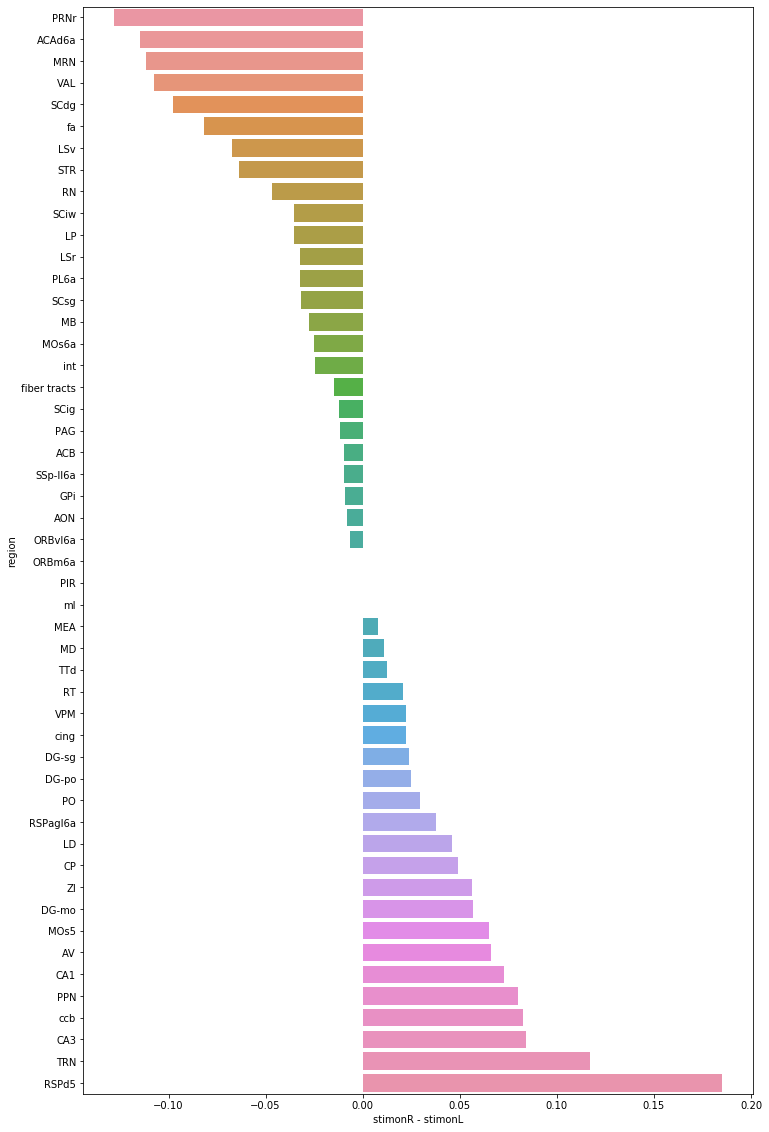

In [12]:
nunit_criterion = 60
high_count_regs = [region for region in tot_units if tot_units[region] > nunit_criterion]
region_props = [{'region': reg, 'n_units': tot_units[reg],
                 **{key : sig_count[reg][key] / tot_units[reg] for key in sig_count[reg] if key != 'scores'}}
                for reg in high_count_regs]
proportiondf = pd.DataFrame(region_props)
proportiondf['difference'] = proportiondf.stimonR - proportiondf.stimonL
sortdf = proportiondf.sort_values('difference')
fig, axes = plt.subplots(1, 1, figsize=(12, 20))
sns.barplot(x='difference', y='region', data=sortdf, ax=axes)
plt.xlabel('stimonR - stimonL')

(-0.05, 0.7)

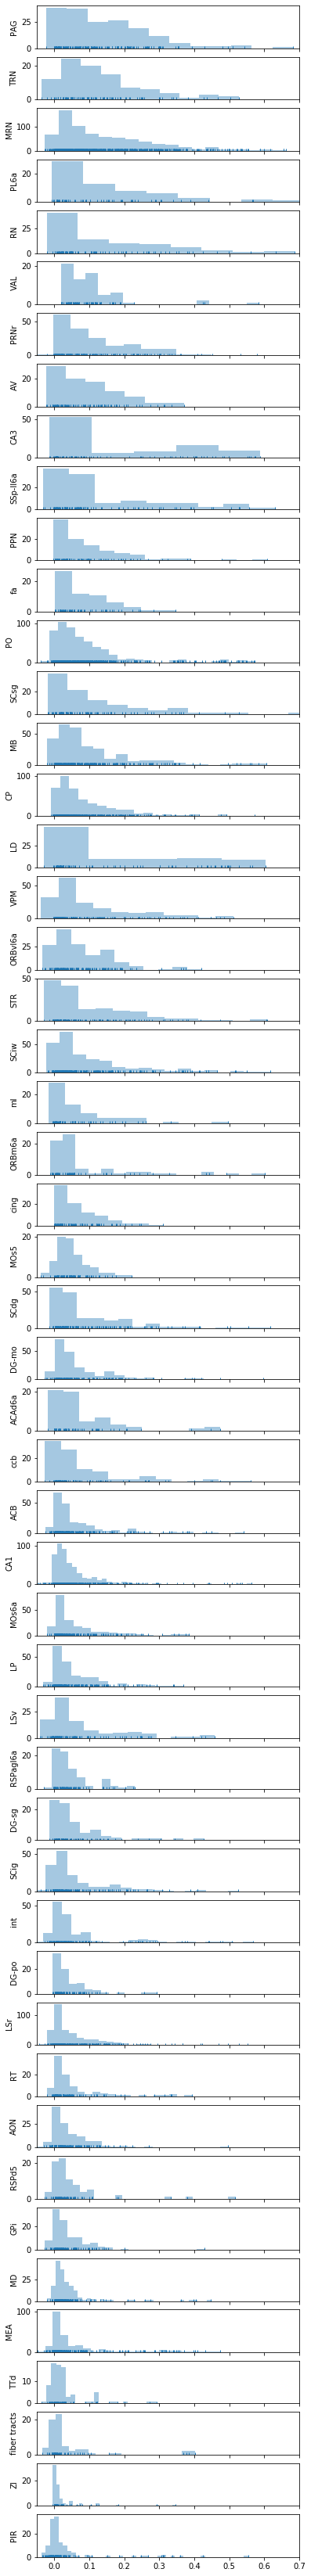

In [13]:
fig, axes = plt.subplots(len(high_count_regs), 1, figsize=(6, len(high_count_regs) * 1.2), sharex=True)
regseries = pd.DataFrame([{'region': reg, 'mean': np.median(sig_count[reg]['scores'])}
                          for reg in high_count_regs]).set_index('region').sort_values('mean', ascending=False)
for i, reg in enumerate(regseries.index):
    sns.distplot(sig_count[reg]['scores'], kde=False, rug=True, ax=axes[i])
    axes[i].set_ylabel(reg)
axes[-1].set_xlim([-0.05, 0.7])

In [14]:
coordsdf = pd.DataFrame([{'x': s['coords'][0],
                          'y': s['coords'][1],
                          'z': s['coords'][2],
                          'median': s['scores'].median()} for s in filedata.values()])
sigdf = pd.DataFrame([{'x': s['coords'][0],
                       'y': s['coords'][1],
                       'z': s['coords'][2],
                       'stimonL': s['significance'].stimonL.mean(),
                       'stimonR': s['significance'].stimonR.mean(),
                       'correct': s['significance'].correct.mean(),
                       'incorrect': s['significance'].incorrect.mean(),
                       'wheel': s['significance'].wheel.mean(),
                       'score_median': s['scores'].median(),
                       'regions': '\n'.join(f'{reg} {count}'
                                            for reg, count in pd.value_counts(s['unit_regions'].acronym, sort=False).iteritems())}
                      for s in filedata.values()])

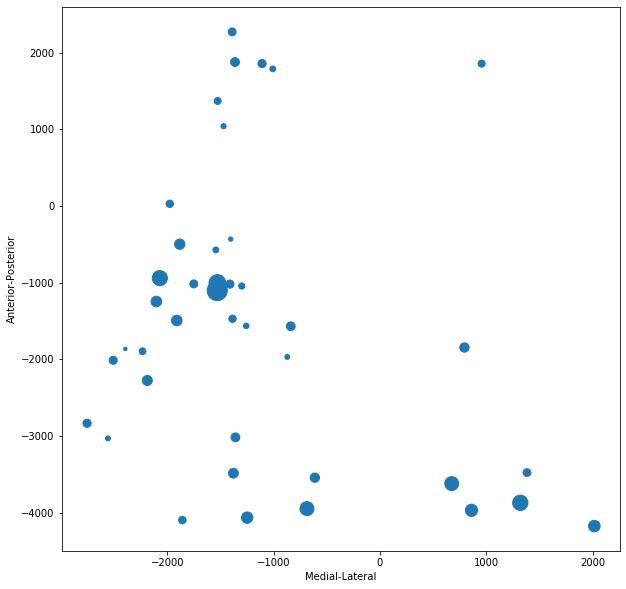

interactive(children=(Dropdown(description='kernel', options=('stimonL', 'stimonR', 'correct', 'incorrect', 'w…

In [19]:
import plotly.express as px

plt.figure(figsize=(10, 10))
plt.scatter(coordsdf.x, coordsdf.y, s=coordsdf['median'] * 1600)
plt.ylabel('Anterior-Posterior')
plt.xlabel('Medial-Lateral')

@interact
def plot_significance(kernel=['stimonL', 'stimonR', 'correct', 'incorrect', 'wheel']):
    fig = plt.figure(figsize=(10, 10))
    cmap = np.array(sns.cubehelix_palette(50, start=.5, rot=-.75))
    cbins = np.linspace(0, 1, 50)
    cbinned = np.digitize(sigdf[kernel], cbins)
    cbinned[cbinned > 99] = 99
    fig = px.scatter(sigdf, 'x', 'y', color=kernel, size=kernel, hover_name='regions', title=kernel)
    fig.show()

In [109]:
planvactual = pd.DataFrame([{'px': s['planned_coords'][0],
                             'py': s['planned_coords'][1],
                             'pz': s['planned_coords'][2],
                             'x': s['coords'][0],
                             'y': s['coords'][1],
                             'z': s['coords'][2]} for s in filedata.values()])

In [22]:
for fn in missing_units:
    print(fn, len(missing_units[fn]))

./fits/KS023/2019-12-10_session_2020-09-04_probe0_fit.p 9
./fits/KS023/2019-12-10_session_2020-09-04_probe1_fit.p 179
./fits/CSHL049/2020-01-11_session_2020-09-04_probe1_fit.p 119
./fits/CSHL049/2020-01-11_session_2020-09-04_probe0_fit.p 1
./fits/ZM_2245/2020-01-21_session_2020-09-04_probe0_fit.p 199
./fits/ZM_2245/2020-01-21_session_2020-09-04_probe1_fit.p 7
./fits/CSHL051/2020-02-05_session_2020-09-04_probe0_fit.p 104
./fits/CSHL052/2020-02-19_session_2020-09-04_probe0_fit.p 5
./fits/CSHL052/2020-02-20_session_2020-09-04_probe1_fit.p 40
./fits/CSHL054/2020-02-11_session_2020-09-04_probe1_fit.p 27
./fits/KS016/2019-12-09_session_2020-09-04_probe0_fit.p 5
./fits/KS016/2019-12-08_session_2020-09-04_probe0_fit.p 3
./fits/KS016/2019-12-08_session_2020-09-04_probe1_fit.p 9
./fits/KS016/2019-12-09_session_2020-09-04_probe1_fit.p 36
./fits/CSHL047/2020-01-22_session_2020-09-04_probe1_fit.p 8
./fits/CSHL047/2020-01-22_session_2020-09-04_probe0_fit.p 162
./fits/CSHL047/2020-01-20_session_2020-